In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Loading data with column date as index
dataset_folder="dataset"
filename="IBM_2006-01-01_to_2018-01-01.csv"

dataset = pd.read_csv(dataset_folder + "/" + filename, index_col='Date', parse_dates=True)

In [3]:
# Preview the data
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [4]:
# Forecast between these dates
test_start_date = datetime.datetime.strptime('2017-01-01', '%Y-%m-%d')
test_end_date = datetime.datetime.strptime('2017-12-31', '%Y-%m-%d')

In [5]:
# Column to be selected
column=1

In [6]:
# We split the data into training and test sets
# Only we take the High column
data_set = dataset.iloc[:, column:column+1]
training_set = dataset[:test_start_date - datetime.timedelta(1)].iloc[:, column:column+1]
test_set = dataset[test_start_date:test_end_date].iloc[:, column:column+1]

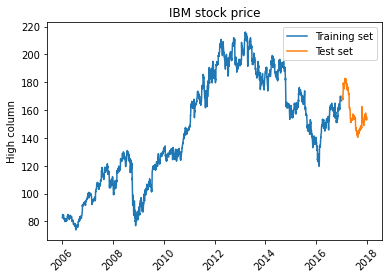

In [7]:
# Plotting training and test sets
stock = filename.split("_",1)[0]
plt.plot(training_set)
plt.plot(test_set)
plt.title(stock + ' stock price')
plt.legend(['Training set', 'Test set'])
plt.ylabel(dataset.columns[column] + ' column')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Scaling between 0,1 the training data
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [9]:
# We prepare the data with memory, each element contain the "memory" variable previous training elements 
memory=260
X_train = []
y_train = []
for i in range(memory, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-memory:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Design of the LSTM RNN
model = Sequential()

# Input layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# First intermediate layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second intermediate layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third intermediate layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compiling
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting
model.fit(X_train, y_train, epochs=10, batch_size=5)

Epoch 1/10
502/502 [==============================] - 29s 58ms/step - loss: 0.0121
Epoch 2/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0060
Epoch 3/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0045
Epoch 4/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0035
Epoch 5/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0030
Epoch 6/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0027
Epoch 7/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0024
Epoch 8/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0022
Epoch 9/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0022
Epoch 10/10
502/502 [==============================] - 30s 60ms/step - loss: 0.0019


In [11]:
# Prepairing the data for RNN
inputs = data_set[len(data_set) - len(test_set) - memory:len(data_set) - len(test_set)].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [12]:
# LTSM RNN running
for i in range(0, len(test_set)):
    X_test = []
    if (i != 0): inputs = np.vstack([inputs, predicted_stock_price[i-1]])
    X_test.append(inputs[i:])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    if (i == 0): predicted_stock_price = np.array(model.predict(X_test))
    else: predicted_stock_price = np.vstack([predicted_stock_price, model.predict(X_test)])

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [13]:
predicted_set = pd.DataFrame(data=predicted_stock_price, index=dataset[test_start_date:test_end_date].index, columns=[column])

In [14]:
# Holt-Winters algorithm running
season=260

df = dataset.resample('B').mean().ffill()
train, test = df[:test_start_date - datetime.timedelta(1)].iloc[:,column], \
              df[test_start_date:test_end_date].iloc[:,column]
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=season).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

/home/davidglt/RNNvsHoltWinters/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


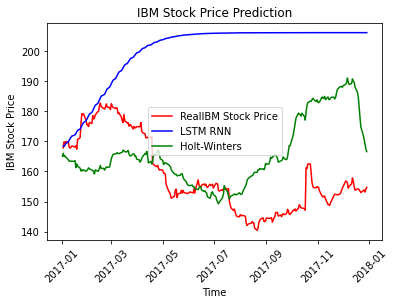

In [15]:
# Plotting the graphs
plt.plot(test_set, color='red', label='Real' + stock + ' Stock Price')
plt.plot(predicted_set, color='blue', label='LSTM RNN')
plt.plot(pred, color='green', label='Holt-Winters')
plt.title(stock + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock + ' Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [16]:
# Evaluating our models with RMSE
rnn_rmse = math.sqrt(mean_squared_error(test_set, predicted_set))
hw_rmse = math.sqrt(mean_squared_error(test, pred))
print("The root mean squared error for RNN is {}.".format(rnn_rmse))
print("The root mean squared error for Holt-Winters is {}.".format(hw_rmse))

The root mean squared error for RNN is 46.78036578621208.
The root mean squared error for Holt-Winters is 18.30616820346266.
